# The Advanced Lane Finding

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
import pickle

In [2]:
# a helper function to display the original image and proccessed image side by side
def display2images(left_img, right_img, left_title="Original", right_title="Processed", left_gray=False, right_gray=False):
    """
    displays two images side by side in one cell.
    """
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    if left_gray:
        ax1.imshow(left_img, cmap="gray")
    else:
        ax1.imshow(left_img)
    ax1.set_title(left_title, fontsize=50)
    if right_gray:
        ax2.imshow(right_img, cmap="gray")
    else:
        ax2.imshow(right_img)
    ax2.set_title(right_title, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

---

### Rubric 1-1: Camera Callibaration & undistort image

In [3]:
def calibrate_camera(calibrate_images, nx=9, ny=6):
    objpoints = []
    imgpoints = []

    objp = np.zeros((ny*nx, 3), np.float32)
    objp[:,0:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    for fname in calibrate_images:
        img = cv2.imread(fname)
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        # If found
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)            
    return ret, mtx, dist, rvecs, tvecs

ret, mtx, dist, rvecs, tvecs = calibrate_camera(glob.glob("./camera_cal/calibration*.jpg"))

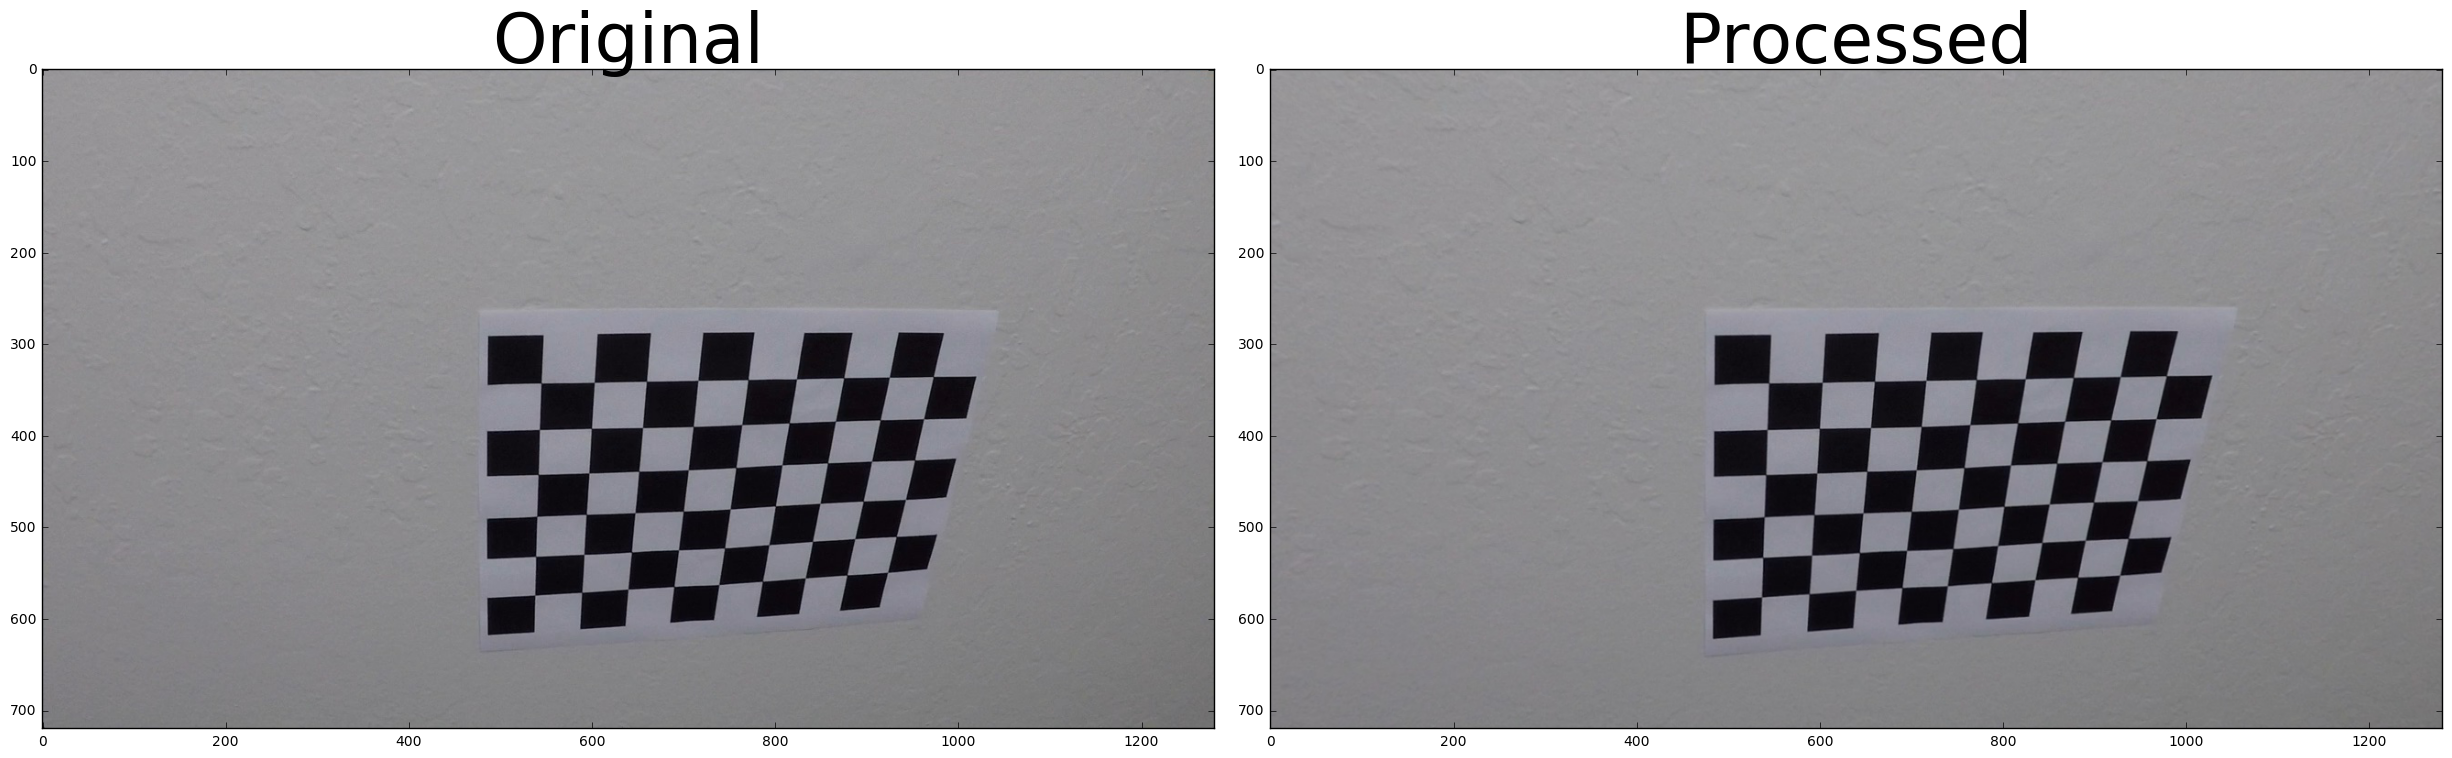

In [4]:
test_image = plt.imread('./camera_cal/calibration10.jpg')
undistored_image = cv2.undistort(test_image, mtx, dist)
display2images(test_image, undistored_image)

### Rubric 2-1: undistort a test image

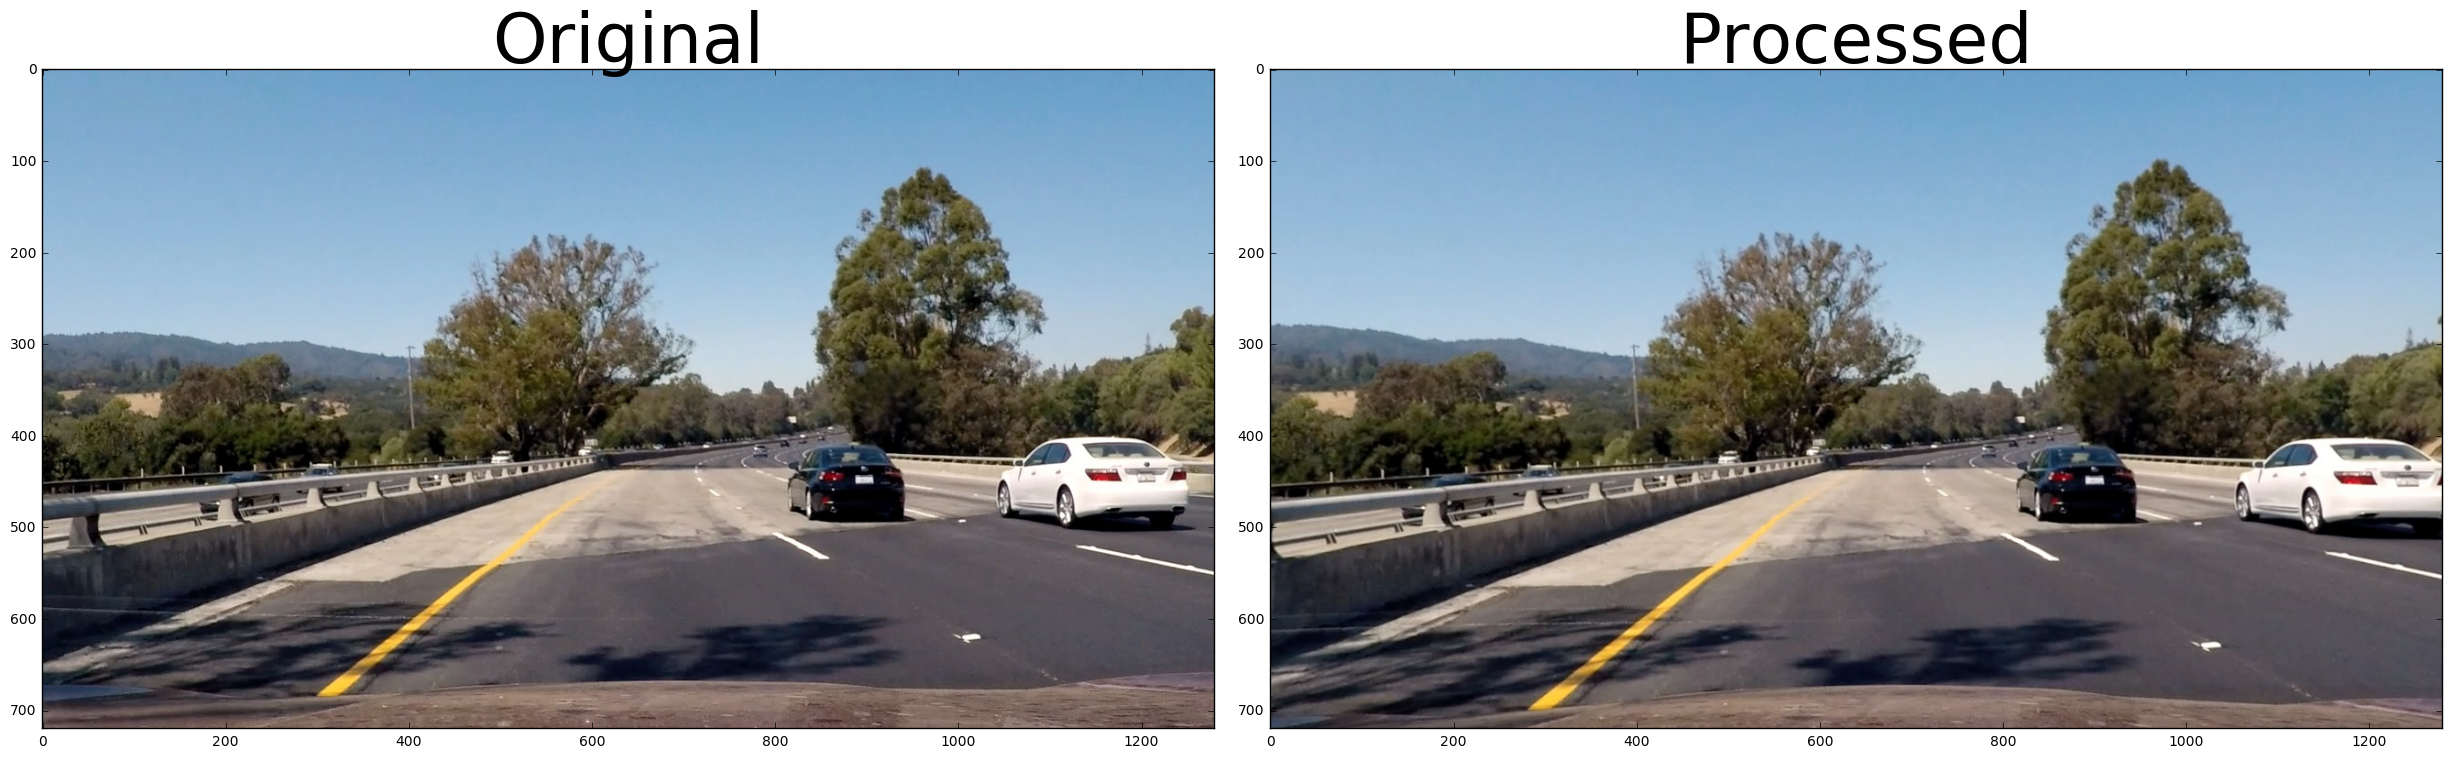

In [5]:
test_image = plt.imread('./test_images/test4.jpg')
undistored_image = cv2.undistort(test_image, mtx, dist)
display2images(test_image, undistored_image)

### Rubric 2-2: gradient and color threshold

In [6]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply cv2.Sobel()
    if orient == "x":
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the output from cv2.Sobel()
    abs_sobel = np.absolute(sobel)
    # Scale the result to an 8-bit range (0-255)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))    
    # Apply lower and upper thresholds
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Create binary_output
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    binary_output = np.ones_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 0
    return binary_output

# combien the threshold
def combine_thresh(img, ksize=3, sobel_thresh=(30, 255), hls_thresh=(0, 160)):
    gradx = abs_sobel_thresh(test_image, orient='x', sobel_kernel=ksize, thresh=sobel_thresh)
    hls_binary = hls_select(img, thresh=hls_thresh)
    
    combined = np.zeros_like(hls_binary)
    combined[((gradx == 1)) | (hls_binary == 1)] = 1
    return combined

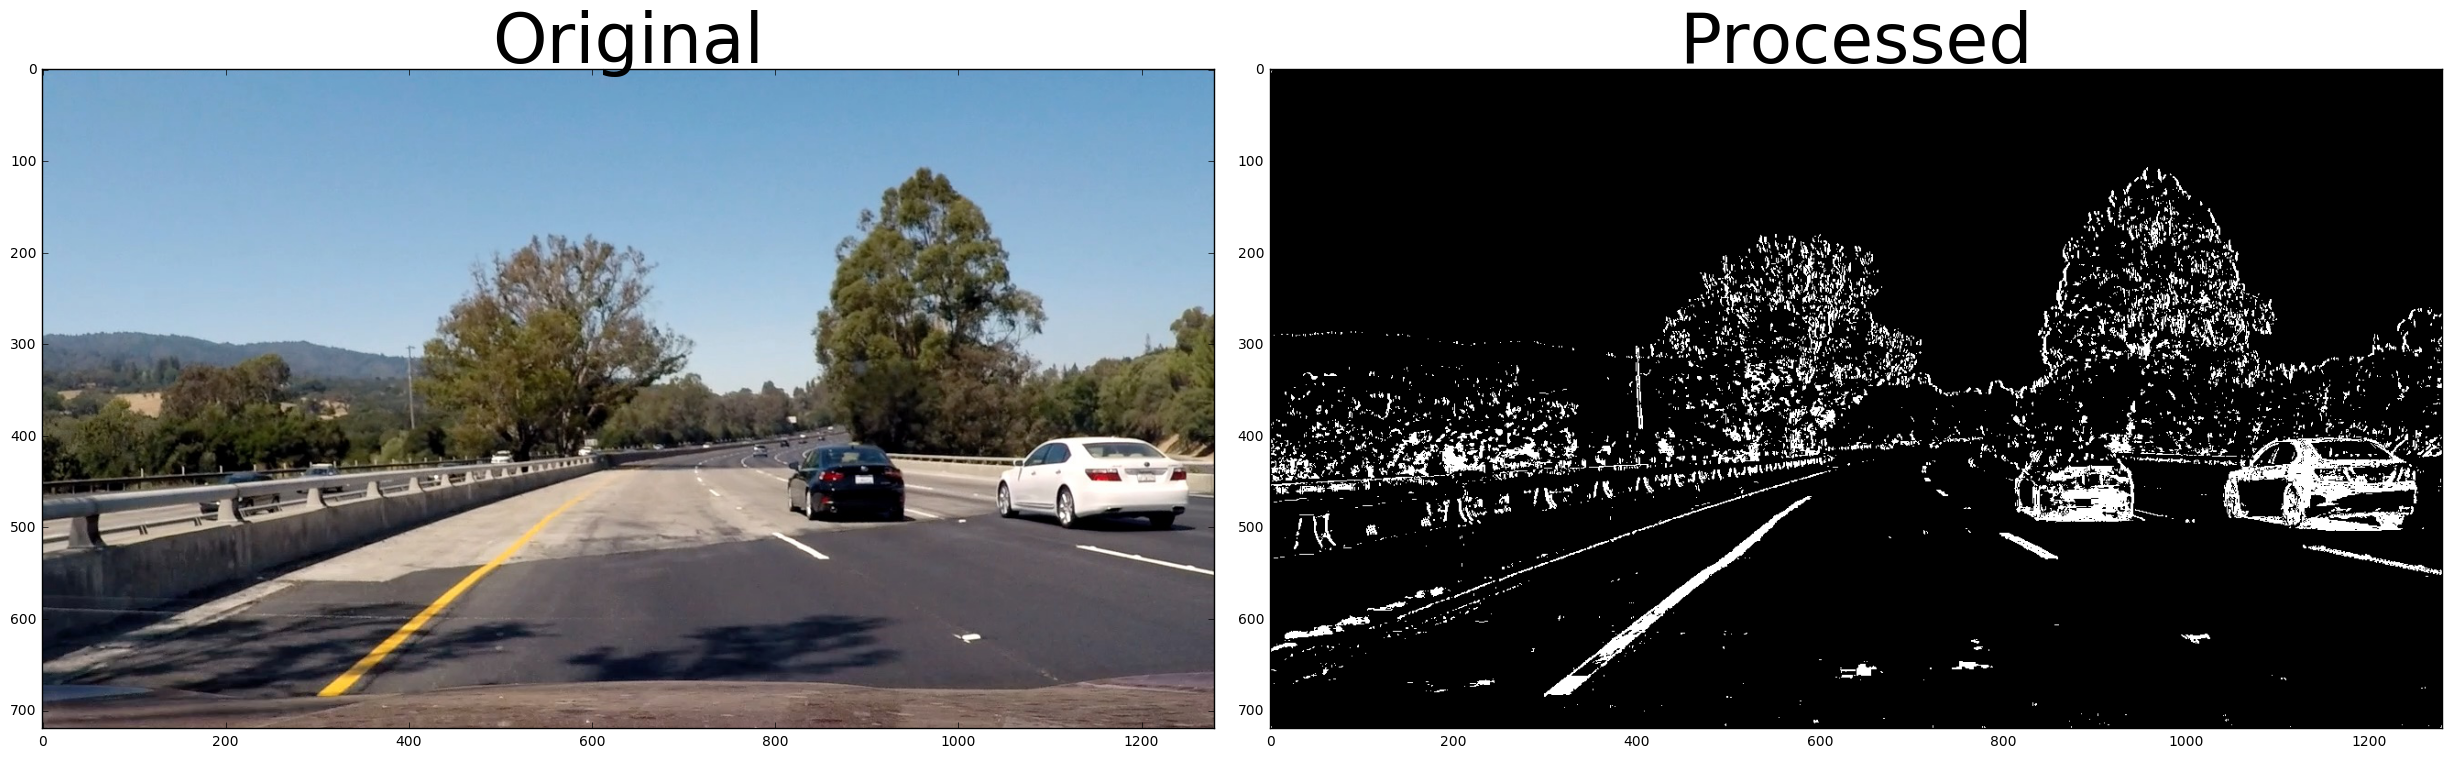

In [7]:
test_image = plt.imread("./test_images/test4.jpg")
display2images(test_image, combine_thresh(test_image, hls_thresh=(0,160)), right_gray=True)

### Rubric 2-3 perspective transform

In [8]:
def warp_image(img, src=None, dst=None):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    # get transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # get inverse transform matrix 
    Minv = cv2.getPerspectiveTransform(dst, src)
    # the the transformed image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return M, Minv, warped

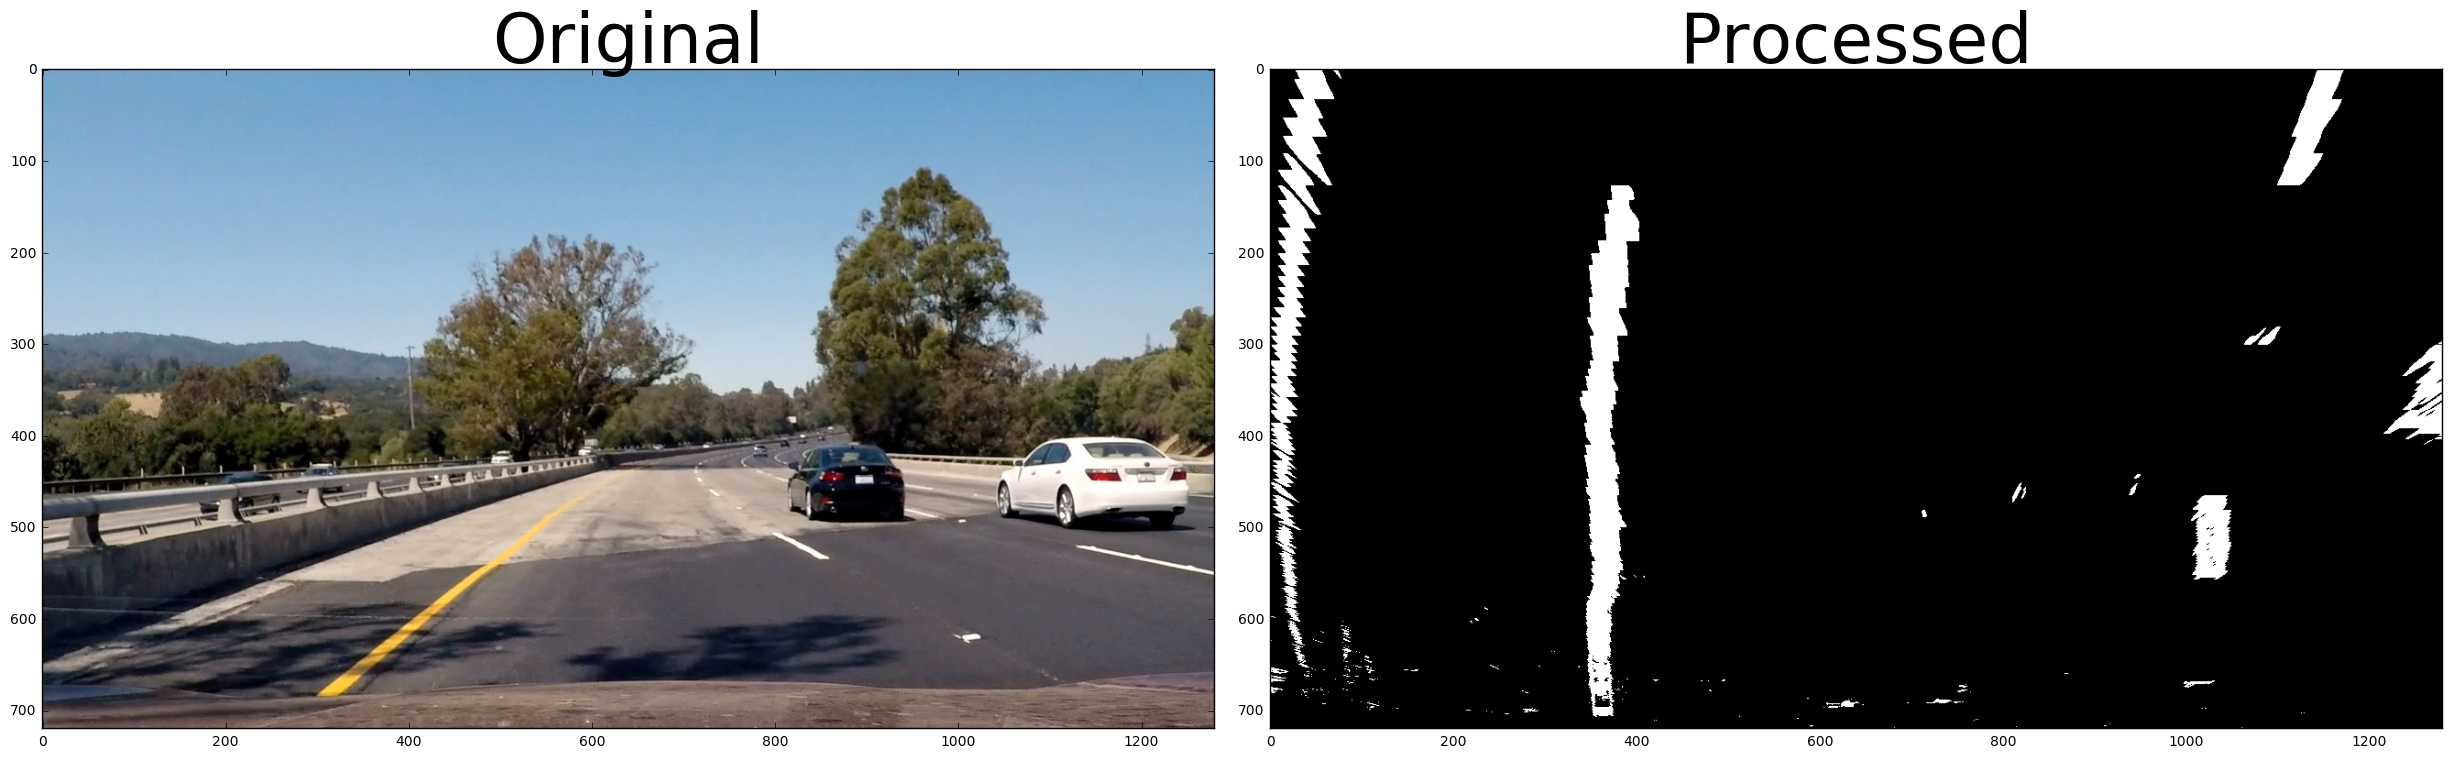

In [9]:
test_image = plt.imread("./test_images/test4.jpg")
_, Minv, warped_image = warp_image(combine_thresh(test_image))
display2images(test_image, warped_image, right_gray=True)

### Rubric 2-4, indentifying the lane line pixels

In [10]:
def fit_line(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Find the peak of the left halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 100
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]     
#     rightx = nonzerox[right_lane_inds]
#     righty = nonzeroy[right_lane_inds]
    rightx = leftx + 600
    righty = lefty

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds


def display_the_fitted_line(binary_warped):
    
    left_fit, right_fit, left_lane_inds, right_lane_inds = fit_line(binary_warped)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

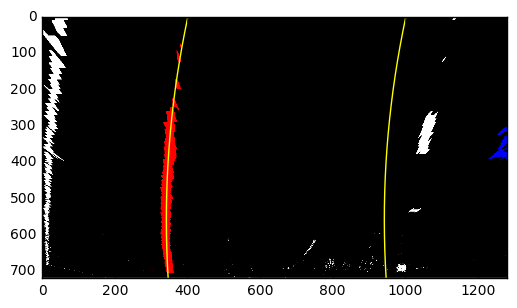

In [11]:
test_image = plt.imread("./test_images/test1.jpg")
_, Minv, warped_image = warp_image(combine_thresh(test_image))
display_the_fitted_line(warped_image)

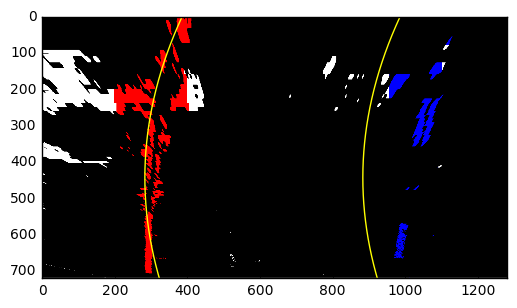

In [12]:
test_image = plt.imread("./test_images/test5.jpg")
_, Minv, warped_image = warp_image(combine_thresh(test_image))
display_the_fitted_line(warped_image)

### Rubric 2-5, finding lane curvature

In [13]:
def calculate_curvature(point_coord, left_fit, right_fit):
    
    pixel_in_y = 720
    pixel_in_x = 1280  
    meters_in_x = 3.7
    meters_in_y = 30
    
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, pixel_in_y-1, num=pixel_in_y)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                  for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Plot up the fake data
    mark_size = 3
    plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
    plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
    plt.xlim(0, pixel_in_x)
    plt.ylim(0, pixel_in_y)
    plt.plot(left_fitx, ploty, color='green', linewidth=3)
    plt.plot(right_fitx, ploty, color='green', linewidth=3)
    plt.gca().invert_yaxis() # to visualize as we do the images
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = point_coord
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
        # Define conversions in x and y from pixels space to meters
#     ym_per_pix = 30/720 # meters per pixel in y dimension
#     xm_per_pix = 3.7/1280 # meters per pixel in x dimension
    
    ym_per_pix = float(meters_in_y/pixel_in_y) # meters per pixel in y dimension
    xm_per_pix = meters_in_x/pixel_in_x # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    
    return (left_curverad, right_curverad)


1022.73875065 m 1054.40229233 m


(1022.738750650846, 1054.4022923300492)

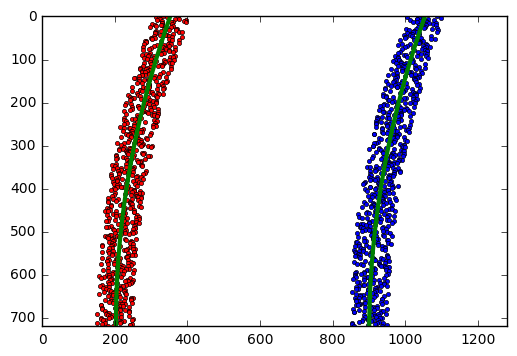

In [15]:
test_image = plt.imread("./test_images/test4.jpg")
_, Minv, warped_image = warp_image(combine_thresh(test_image))
left_fit, right_fit, _, _ = fit_line(warped_image)
calculate_curvature(test_image.shape[0], left_fit, right_fit)

### Rubric 2-6 pipline 

In [16]:
def pipeline(img, mtx, dist):
    # undistort the image using calibration matrix
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)

    # color transformation
    tranformed = combine_thresh(undistorted)

    # do warp
    _, Minv, binary_warped = warp_image(tranformed)
    
    # filling the identified lane area
    # fit line
    left_fit, right_fit, _, _ = fit_line(binary_warped)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    return result

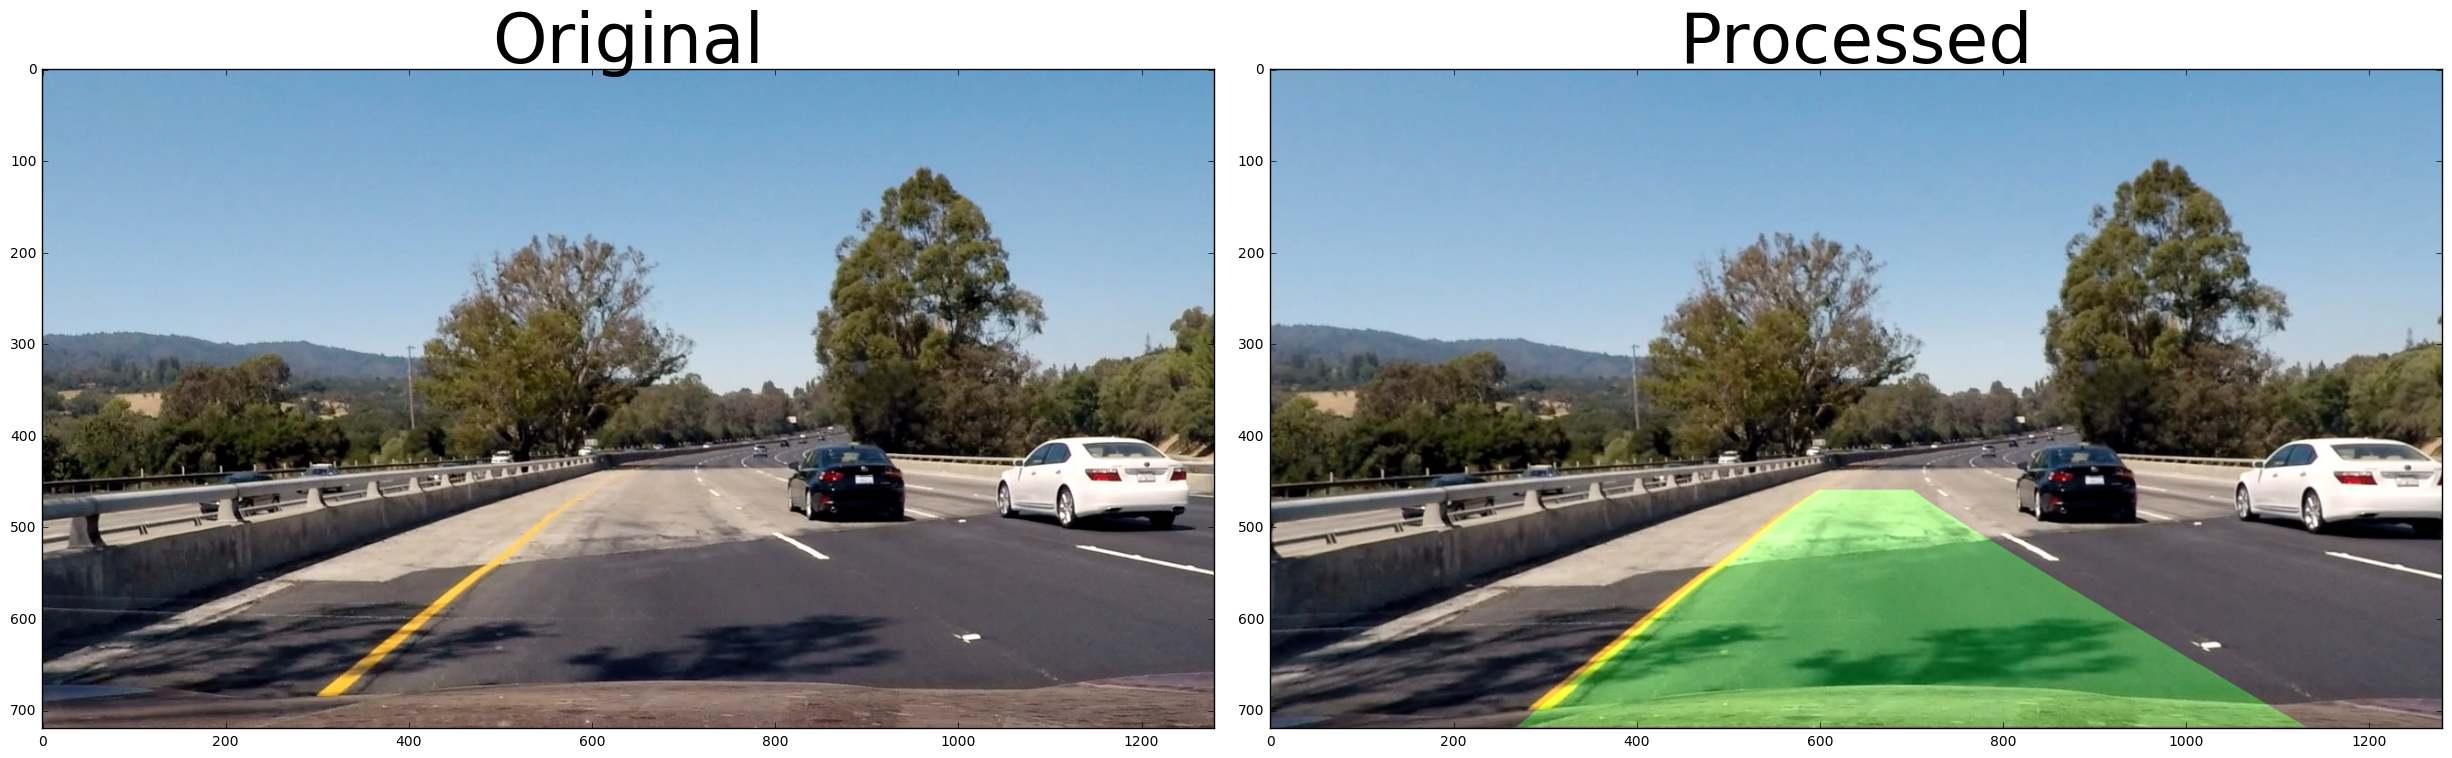

In [17]:
test_image = plt.imread("./test_images/test4.jpg")
filled_image = pipeline(test_image, mtx, dist)
display2images(test_image, filled_image)

### Rubric 3 Applying pipline to video

In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [19]:
def process_image(image):
    result = pipeline(image, mtx, dist)
    return result

In [21]:
output_video = 'project_video_output.mp4'
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [02:34<00:00,  8.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min, sys: 24.3 s, total: 3min 25s
Wall time: 2min 36s


In [22]:
# output_video = "output_20170409.mp4"
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))